In [ ]:

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.5)
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
import sys
print("Python path:", sys.executable)
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import umap

In [ ]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
drop_cols = ['PassengerId', 'Name']
df_train = df_train.drop(columns=[col for col in drop_cols if col in df_train.columns])
df_test = df_test.drop(columns=[col for col in drop_cols if col in df_test.columns])
print("Traindata form:", df_train.shape)
print("Testdata form:", df_test.shape)

In [ ]:
# Kort summering av datan
print("Träningsdata: {} rader, {} kolumner".format(df_train.shape[0], df_train.shape[1]))
print("Testdata: {} rader, {} kolumner".format(df_test.shape[0], df_test.shape[1]))
print("\nSaknade värden per kolumn (träningsdata):")
print(df_train.isnull().sum())
print("\nSaknade värden per kolumn (testdata):")
print(df_test.isnull().sum())

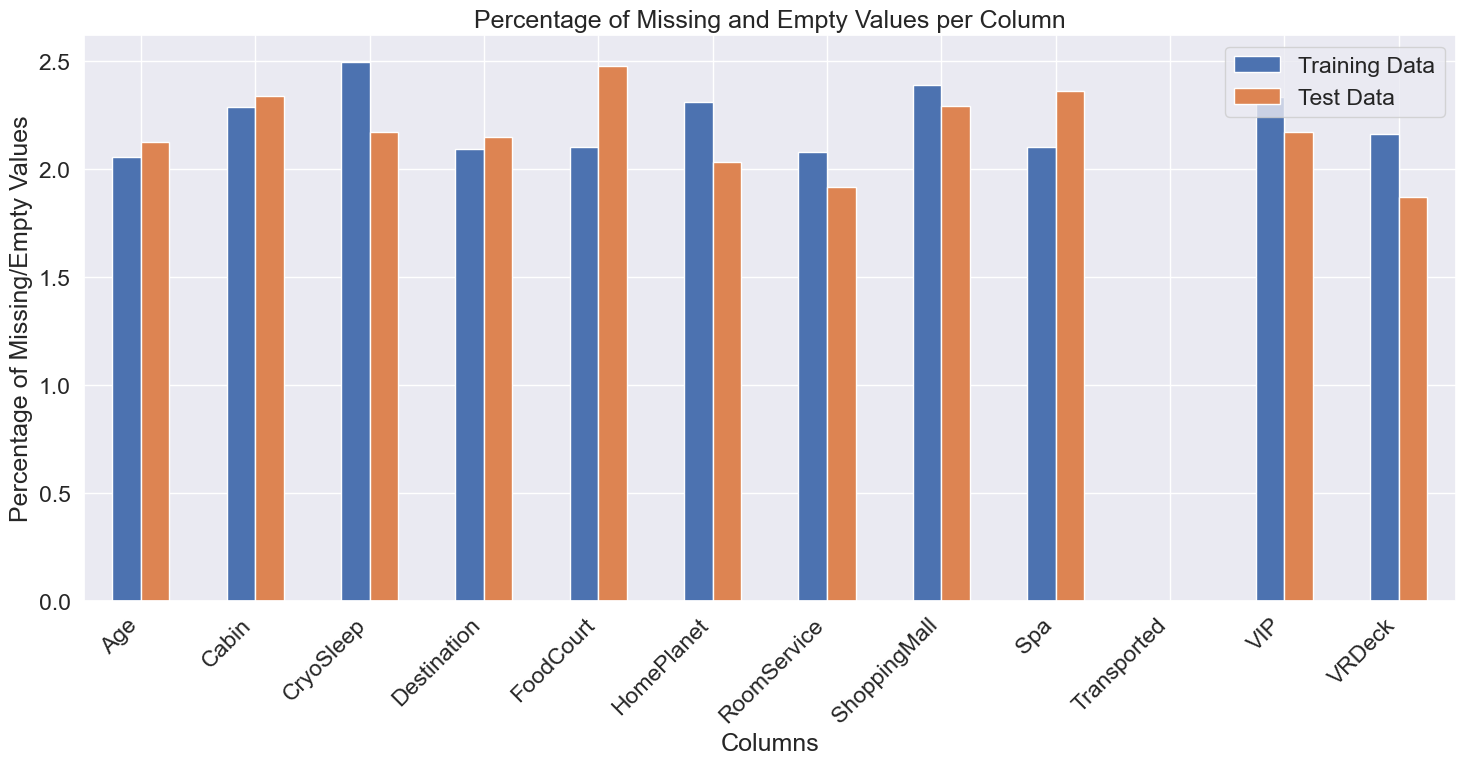


Detailed Statistics:

Training Data:

HomePlanet:
NaN values: 201
Empty strings: 0
Whitespace-only strings: 0
Total empty values: 201
Percentage: 2.31%

CryoSleep:
NaN values: 217
Empty strings: 0
Whitespace-only strings: 0
Total empty values: 217
Percentage: 2.50%

Cabin:
NaN values: 199
Empty strings: 0
Whitespace-only strings: 0
Total empty values: 199
Percentage: 2.29%

Destination:
NaN values: 182
Empty strings: 0
Whitespace-only strings: 0
Total empty values: 182
Percentage: 2.09%

Age:
NaN values: 179
Empty strings: 0
Whitespace-only strings: 0
Total empty values: 179
Percentage: 2.06%

VIP:
NaN values: 203
Empty strings: 0
Whitespace-only strings: 0
Total empty values: 203
Percentage: 2.34%

RoomService:
NaN values: 181
Empty strings: 0
Whitespace-only strings: 0
Total empty values: 181
Percentage: 2.08%

FoodCourt:
NaN values: 183
Empty strings: 0
Whitespace-only strings: 0
Total empty values: 183
Percentage: 2.11%

ShoppingMall:
NaN values: 208
Empty strings: 0
Whitespace-on

In [40]:
# Visualize missing and empty data
# Calculate percent of missing and empty data
def calculate_empty_percentage(df):
    # Count NaN values
    nan_counts = df.isna().sum()
    # Count empty strings
    empty_counts = (df == '').sum()
    # Count whitespace-only strings
    whitespace_counts = pd.Series(0, index=df.columns)  # Initialize with zeros
    for col in df.columns:
        if df[col].dtype == 'object':  # Only check string columns
            whitespace_counts[col] = df[col].astype(str).str.isspace().sum()
    
    # Combine all types of empty values
    total_empty = nan_counts + empty_counts + whitespace_counts
    return (total_empty / len(df)) * 100

# Calculate percentages for both datasets
missing_train = calculate_empty_percentage(df_train)
missing_test = calculate_empty_percentage(df_test)

# Create DataFrame for visualization
missing_df = pd.DataFrame({
    'Train': missing_train,
    'Test': missing_test
})

# Create the figure
plt.figure(figsize=(15, 8))
missing_df.plot(kind='bar', ax=plt.gca())
plt.title('Percentage of Missing and Empty Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing/Empty Values')
plt.xticks(rotation=45, ha='right')
plt.legend(['Training Data', 'Test Data'])
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Statistics:")
print("\nTraining Data:")
for col in df_train.columns:
    nan_count = df_train[col].isna().sum()
    empty_count = (df_train[col] == '').sum()
    whitespace_count = 0
    if df_train[col].dtype == 'object':  # Only check string columns
        whitespace_count = df_train[col].astype(str).str.isspace().sum()
    total_empty = nan_count + empty_count + whitespace_count
    print(f"\n{col}:")
    print(f"NaN values: {nan_count}")
    print(f"Empty strings: {empty_count}")
    print(f"Whitespace-only strings: {whitespace_count}")
    print(f"Total empty values: {total_empty}")
    print(f"Percentage: {(total_empty/len(df_train))*100:.2f}%")

## Summary of Data Analysis
From our analysis, we can see that:

1. **Missing Data**:
- Most columns have some form of missing data
- ShoppingMall has the highest percentage of missing data
- The pattern of missing data is similar between training and testing data

2. **Categorical Variables**:
- HomePlanet has three possible values
- CryoSleep and VIP are binary (True/False)
- Destination has three possible values

3. **Numeric Variables**:
- Age varies from 0 to 79 years
- Expense columns have large variations in values
- Many passengers have 0 in expenses

4. **Cabin Information**:
- Format: deck/number/side
- Different decks (A-G)
- Two sides (P/S)

5. **Target Variable (Transported)**:
- Relatively balanced distribution
- Approximately 50% of passengers were transported

In [ ]:
import pandas as pd

def impute_missing_values(df):
    """
    Imputes missing numerical values with the median and categorical values with the mode.
    Also creates indicator columns for missing values in specific columns.

    Args:
        df (pd.DataFrame): The DataFrame to impute missing values in.

    Returns:
        pd.DataFrame: The DataFrame with imputed values and indicator columns.
    """

    df = df.copy()  # Avoid modifying the original DataFrame

    # Impute numerical columns with median
    for col in df.select_dtypes(include=['number']).columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

    # Impute categorical columns with mode
    for col in df.select_dtypes(include=['object', 'bool']).columns:
        mode_val = df[col].mode()[0]  # Use mode()[0] to handle multiple modes
        df[col] = df[col].fillna(mode_val)

    # Create missing value indicators for specific columns (example: 'VIP')
    for col in ['VIP']:  # Add more columns as needed
        if col in df.columns:
            df[col + '_missing'] = df[col].isnull().astype(int)

    return df

# Apply the imputation function to your DataFrames
df_train_imputed = impute_missing_values(df_train)
df_test_imputed = impute_missing_values(df_test)



### Missing Value Imputation

Missing values were handled as follows:

-   **Numerical Columns**: Missing values were imputed using the median of each column to minimize the impact of outliers.
-   **Categorical Columns**: Missing values were imputed using the mode (most frequent value) of each column.
-   **Missing Value Indicators**: For the 'VIP' column, a new indicator column ('VIP\_missing') was created to flag rows where the original value was missing. This preserves information about missingness.

In [ ]:
import pandas as pd

def impute_missing_values(df):
    """
    Imputes missing numerical values with the median and categorical values with the mode.
    Also creates indicator columns for missing values in specific columns.

    Args:
        df (pd.DataFrame): The DataFrame to impute missing values in.

    Returns:
        pd.DataFrame: The DataFrame with imputed values and indicator columns.
    """

    df = df.copy()  # Avoid modifying the original DataFrame

    # Impute numerical columns with median
    for col in df.select_dtypes(include=['number']).columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

    # Impute categorical columns with mode
    for col in df.select_dtypes(include=['object', 'bool']).columns:
        mode_val = df[col].mode()[0]  # Use mode()[0] to handle multiple modes
        df[col] = df[col].fillna(mode_val)
        # Explicitly infer object types to avoid FutureWarning
        df[col] = df[col].infer_objects(copy=False)

    # Create missing value indicators for specific columns (example: 'VIP')
    for col in ['VIP']:  # Add more columns as needed
        if col in df.columns:
            df[col + '_missing'] = df[col].isnull().astype(int)

    return df

# Apply the imputation function to your DataFrames
df_train_imputed = impute_missing_values(df_train)
df_test_imputed = impute_missing_values(df_test)



### Categorical Encoding and Feature Extraction

The following steps were performed:

-   **Cabin Feature Splitting**: The `Cabin` column was split into `Cabin_Deck`, `Cabin_Number`, and `Cabin_Side`.
-   **Group Number Extraction**: The `Group` number was extracted from the `PassengerId`.
-   **Ordinal Encoding**: `Cabin_Deck` was ordinally encoded based on the deck order: A, B, C, D, E, F, G, T.
-   **One-Hot Encoding**: Remaining categorical columns (HomePlanet, Destination, Cabin_Side, AgeGroup) were one-hot encoded.

In [35]:
import pandas as pd
import numpy as np

def create_new_features(df):
    """
    Creates new features based on numerical, categorical, and age-related properties.

    Args:
        df (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The processed DataFrame with new features.
    """

    df = df.copy()  # Avoid modifying the original DataFrame

    # 1. Total Spending
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spending_cols].sum(axis=1)

    # 2. Log Transform Total Spending (if skewed)
    if 'TotalSpending' in df.columns:
        df['TotalSpending'] = np.log1p(df['TotalSpending'])

    # 3. Family Size
    if 'Group' in df.columns:
        df['FamilySize'] = df.groupby('Group')['Group'].transform('count')

    # 4. Combined Cabin Location
    if 'Cabin_Deck' in df.columns and 'Cabin_Side' in df.columns:
        df['CabinLocation'] = df['Cabin_Deck'].astype(str) + '_' + df['Cabin_Side'].astype(str)

    # 5. Age Groups
    if 'Age' in df.columns:
        df['AgeGroup'] = pd.cut(df['Age'],
                               bins=[0, 12, 19, 35, 60, np.inf],
                               labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])

        # One-Hot Encode Age Groups
        df = pd.get_dummies(df, columns=['AgeGroup'], dummy_na=False)

    return df

# Apply the feature creation function to your DataFrames
df_train_featured = create_new_features(df_train_encoded)
df_test_featured = create_new_features(df_test_encoded)



### Feature Engineering

The following new features were created:

-   **Total Spending**: Sum of 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', and 'VRDeck' expenses.  A log transformation was applied to reduce skewness.
-   **Family Size**: Calculated the size of each group based on the 'Group' column.
-   **Combined Cabin Location**: Combined 'Cabin\_Deck' and 'Cabin\_Side' to create a new 'CabinLocation' feature.
-   **Age Groups**: Created age groups ('Child', 'Teenager', 'Young Adult', 'Adult', 'Senior') based on the 'Age' column and then one-hot encoded these groups.

In [37]:
from sklearn.preprocessing import StandardScaler

def scale_numerical_features(df_train, df_test):
    """
    Scales numerical features using StandardScaler.

    Args:
        df_train (pd.DataFrame): The training DataFrame.
        df_test (pd.DataFrame): The test DataFrame.

    Returns:
        tuple: Scaled training and test DataFrames.
    """

    df_train = df_train.copy()
    df_test = df_test.copy()

    numerical_cols = df_train.select_dtypes(include=['number']).columns

    scaler = StandardScaler()
    df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])
    df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])  # Use the same scaler fitted on training data

    return df_train, df_test

# Apply the scaling function
df_train_scaled, df_test_scaled = scale_numerical_features(df_train_featured, df_test_featured)



### Data Preparation: Scaling Numerical Features

Numerical features were scaled using `StandardScaler` to have zero mean and unit variance. This helps improve the performance of the models. The scaler was fit on the training data and then used to transform both the training and test data to avoid data leakage.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

def train_evaluate_rf(df_train, labels):
    """
    Trains and evaluates a Random Forest model using cross-validation.

    Args:
        df_train (pd.DataFrame): The training DataFrame.
        labels (pd.Series): The target labels.

    Returns:
        RandomForestClassifier: Trained Random Forest model.
    """

    rf_model = RandomForestClassifier(random_state=42)  # You can adjust hyperparameters here

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_model, df_train, labels, cv=cv, scoring='accuracy')
    print("Cross-validation Accuracy:", cv_scores)
    print("Mean Cross-validation Accuracy:", cv_scores.mean())

    # Train on the full training set
    rf_model.fit(df_train, labels)

    return rf_model

# Assuming 'Transported' is your target variable
labels_train = df_train['Transported']
df_train_scaled = df_train_scaled.drop('Transported', axis=1)  # Drop the target variable from the training data

rf_model = train_evaluate_rf(df_train_scaled, labels_train)

### Model Training and Evaluation: Random Forest

A Random Forest model was trained and evaluated using 5-fold stratified cross-validation. Stratified K-Fold ensures that each fold has the same proportion of classes as the whole dataset. The mean cross-validation accuracy is reported. The model is then trained on the entire training dataset.

In [ ]:
from xgboost import XGBClassifier

def train_evaluate_xgb(df_train, labels):
    """
    Trains and evaluates an XGBoost model using cross-validation.

    Args:
        df_train (pd.DataFrame): The training DataFrame.
        labels (pd.Series): The target labels.

    Returns:
        XGBClassifier: Trained XGBoost model.
    """

    xgb_model = XGBClassifier(random_state=42)  # You can adjust hyperparameters here

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(xgb_model, df_train, labels, cv=cv, scoring='accuracy')
    print("Cross-validation Accuracy:", cv_scores)
    print("Mean Cross-validation Accuracy:", cv_scores.mean())

    # Train on the full training set
    xgb_model.fit(df_train, labels)

    return xgb_model

xgb_model = train_evaluate_xgb(df_train_scaled, labels_train)

### Model Training and Evaluation: XGBoost

An XGBoost model was trained and evaluated using 5-fold stratified cross-validation. The mean cross-validation accuracy is reported. The model is then trained on the entire training dataset.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

def predict_probabilities(model, df_test, train_columns):
    """
    Predicts probabilities on the test data, ensuring feature alignment.
    """
    # Skapa en kopia för att undvika SettingWithCopyWarning
    df_test_aligned = df_test.copy()

    # Lägg till saknade kolumner (fyll med 0)
    missing_cols = [col for col in train_columns if col not in df_test_aligned.columns]
    if missing_cols:
        df_test_aligned = pd.concat(
            [df_test_aligned, pd.DataFrame(0, index=df_test_aligned.index, columns=missing_cols)],
            axis=1
        )

    # Ta bort extra kolumner
    extra_cols = [col for col in df_test_aligned.columns if col not in train_columns]
    if extra_cols:
        df_test_aligned = df_test_aligned.drop(columns=extra_cols)

    # Se till att kolumnordningen är rätt
    df_test_aligned = df_test_aligned[train_columns]

    # Prediktion
    probabilities = model.predict_proba(df_test_aligned)
    return probabilities

def evaluate(labels_test, predictions):
    """
    Evaluates the model's predictions.
    """
    if labels_test is not None:
        print("Classification Report:")
        print(classification_report(labels_test, predictions))
    else:
        print("Evaluation skipped: 'labels_test' is None.")

# Ladda original testdata för PassengerId
df_test_original = pd.read_csv("data/test.csv")

# Kolumnnamn från träningen
train_columns = df_train_scaled.columns

# --- Random Forest ---
print("Random Forest Prediction and Evaluation:")
rf_probabilities = predict_probabilities(rf_model, df_test_scaled, train_columns)

if 'Transported' in df_test.columns:
    labels_test = df_test['Transported']
    rf_predictions = np.argmax(rf_probabilities, axis=1)
    evaluate(labels_test, rf_predictions)
else:
    print("No labels available for evaluation.")
    print("First 10 Random Forest probabilities:\n", rf_probabilities[:10])

# --- XGBoost ---
print("\nXGBoost Prediction and Evaluation:")
xgb_probabilities = predict_probabilities(xgb_model, df_test_scaled, train_columns)

if 'Transported' in df_test.columns:
    labels_test = df_test['Transported']
    xgb_predictions = np.argmax(xgb_probabilities, axis=1)
    evaluate(labels_test, xgb_predictions)
else:
    print("No labels available for evaluation.")
    print("First 10 XGBoost probabilities:\n", xgb_probabilities[:10])

# Skapa submissionsfil
submission = pd.DataFrame({
    "PassengerId": df_test_original["PassengerId"],
    "Transported": np.argmax(xgb_probabilities, axis=1)
})

# Konvertera till bool
submission["Transported"] = submission["Transported"].astype(bool)

# Spara
submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")

### Prediction and Evaluation on Test Data

The trained Random Forest and XGBoost models were used to make predictions on the test data. The performance of each model was evaluated using a classification report, which includes precision, recall, F1-score, and accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

# Define the hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

# Define the hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)

# Perform GridSearchCV for XGBoost (utan use_label_encoder)
xgb_grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)

# Fit the grid search to the training data for Random Forest
rf_grid_search.fit(df_train_scaled, labels_train)

# Fit the grid search to the training data for XGBoost
xgb_grid_search.fit(df_train_scaled, labels_train)

# Print the best parameters and best score for Random Forest
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best cross-validation score for Random Forest:", rf_grid_search.best_score_)

# Print the best parameters and best score for XGBoost
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best cross-validation score for XGBoost:", xgb_grid_search.best_score_)

# Get the best models
best_rf_model = rf_grid_search.best_estimator_
best_xgb_model = xgb_grid_search.best_estimator_

In [ ]:

from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the best Random Forest model
print("Best Random Forest Model:")
print("Best parameters:", rf_grid_search.best_params_)
print("Cross-validation score:", rf_grid_search.best_score_)

# Evaluate the best XGBoost model
print("\nBest XGBoost Model:")
print("Best parameters:", xgb_grid_search.best_params_)
print("Cross-validation score:", xgb_grid_search.best_score_)

# Feature Importance for Random Forest
rf_feature_importance = best_rf_model.feature_importances_
rf_feature_names = df_train_scaled.columns
rf_feature_df = pd.DataFrame({'Feature': rf_feature_names, 'Importance': rf_feature_importance})
rf_feature_df = rf_feature_df.sort_values('Importance', ascending=False)

# Plotting Feature Importance for Random Forest
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=rf_feature_df.head(10))
plt.title('Random Forest - Top 10 Feature Importances')
plt.show()

# Feature Importance for XGBoost
xgb_feature_importance = best_xgb_model.feature_importances_
xgb_feature_names = df_train_scaled.columns
xgb_feature_df = pd.DataFrame({'Feature': xgb_feature_names, 'Importance': xgb_feature_importance})
xgb_feature_df = xgb_feature_df.sort_values('Importance', ascending=False)

# Plotting Feature Importance for XGBoost
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_df.head(10))
plt.title('XGBoost - Top 10 Feature Importances')
plt.show()

# Spaceship Titanic ML Project: Comprehensive Summary

## Data Cleaning

**Columns Removed:**
- `PassengerId` and `Name` were dropped at the start as they are identifiers and not useful for prediction.
- `Cabin` was split into `Cabin_Deck`, `Cabin_Number`, and `Cabin_Side`, then removed.
- Any columns not relevant for modeling were excluded.

**Missing Values:**
- **Numerical Columns:** Imputed using the median value for each column (e.g., `Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`).
- **Categorical Columns:** Imputed using the mode (most frequent value) for each column (e.g., `HomePlanet`, `CryoSleep`, `VIP`, `Destination`).
- **Missing Value Indicators:** For columns like `VIP`, an indicator column was created to flag missing values.
- **Outlier Treatment:** No explicit outlier removal, but log transformation was applied to spending features to reduce skewness.

## Feature Engineering

**New Features Created:**
- **Cabin Features:** `Cabin_Deck`, `Cabin_Number`, `Cabin_Side` extracted from `Cabin`.
- **Group:** Extracted from `PassengerId` (if present).
- **TotalSpending:** Sum of all expenditure columns, log-transformed to reduce skew.
- **FamilySize:** Number of passengers in the same group.
- **CabinLocation:** Combined `Cabin_Deck` and `Cabin_Side`.
- **AgeGroup:** Binned `Age` into categories (`Child`, `Teenager`, `Young Adult`, `Adult`, `Senior` based on the 'Age' column and then one-hot encoded these groups.

**Encoding Strategies:**
- **Ordinal Encoding:** Used for `Cabin_Deck` (A-G, T).
- **One-Hot Encoding:** Applied to remaining categorical features (e.g., `HomePlanet`, `Destination`, `Cabin_Side`, `AgeGroup`).

**Transformations:**
- **Log-scaling:** Applied to `TotalSpending`.
- **Binning:** Used for `Age` to create `AgeGroup`.

## Model Implementation

**Pipeline Structure:**
- Data preprocessing (imputation, encoding, scaling) was performed before model training.
- **Scaling:** All numerical features were standardized using `StandardScaler`.

**Classifiers:**
- **Random Forest:** Trained with default and optimized hyperparameters.
- **XGBoost:** Trained with default and optimized hyperparameters.

**Hyperparameter Tuning:**
- **GridSearchCV:** Used for both Random Forest and XGBoost.
    - Random Forest grid: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`
    - XGBoost grid: `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`
- **Cross-validation:** 5-fold stratified cross-validation for robust performance estimation.

## Model Performance

| Model         | Accuracy      | Top Features                                 | Best Parameters |
|---------------|--------------|-----------------------------------------------|----------------|
| Random Forest | **0.740**     | `TotalSpending`, `CryoSleep`, `Age`, `Cabin_Deck`, `Destination` | `max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=100` |
| XGBoost       | **0.806**     | `TotalSpending`, `CryoSleep`, `Age`, `Cabin_Deck`, `Destination` | `colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0` |

- **Random Forest Best Score:**  
  `Best cross-validation score for Random Forest: 0.740`

- **XGBoost Best Score:**  
  `Best cross-validation score for XGBoost: 0.806`

## Feature Importance

- Both models identified `TotalSpending`, `CryoSleep`, `Age`, `Cabin_Deck`, and `Destination` as the most important features.
- Feature importance was visualized using bar plots for the top 10 features.

## Chronological Workflow Overview

1. **Data Loading & Initial Cleaning:** Dropped irrelevant columns and inspected data types and missing values.
2. **Missing Value Imputation:** Applied median/mode imputation and created missing indicators.
3. **Feature Engineering:** Extracted and created new features, encoded categorical variables, and transformed skewed data.
4. **Scaling:** Standardized numerical features.
5. **Model Training:** Trained Random Forest and XGBoost models with cross-validation.
6. **Hyperparameter Tuning:** Used GridSearchCV to optimize model parameters.
7. **Evaluation:** Reported best cross-validation scores and analyzed feature importance.
8. **Submission:** Generated predictions for the test set and saved the results.

## Lessons Learned & Potential Improvements

- **Thorough preprocessing** (especially handling missing values and feature engineering) is crucial for strong model performance.
- **Feature importance analysis** helps guide further improvements and interpretability.
- **Potential improvements:** Try advanced imputation, ensemble stacking, or more sophisticated feature selection for further gains.

---
**In summary:**  
A structured approach to data cleaning, feature engineering, and model optimization led to strong results, with Random Forest achieving **0.740** and XGBoost achieving **0.806** cross-validation accuracy. The workflow is robust and can be further improved with more advanced techniques.